In [65]:
# This code creates the random connection matrices needed for a simulation
# of the neuronal network model published in Nature Communications by 
# El-Bousani & Sur (2014).

## Written by Zach Mobille on 8/30/2022
## Georgia Institute of Technology, Choi lab


### import BRIAN, matplotlib, numpy
import brian2
from brian2 import *
prefs.codegen.target = 'numpy'
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for manually-created legend
import random
import sys
np.set_printoptions(threshold=sys.maxsize) # to print the full array

GRID_LENGTH = 2 # mm 2
NRN_SPACING = 0.02 # mm 0.02
NUM_NRNS = int((GRID_LENGTH/NRN_SPACING)**2)

### DEFINE FUNCTIONS ###
def randCust():
  '''
  returns 1 of 3 labels according to a custom distribution
  '''
  x = rand()
  if x <= 0.8:
    ret = 'red' # for PC neurons
  elif 0.8 < x < 0.9:
    ret = 'blue' # for PV neurons
  else:
    ret = 'green' # for SOM neurons
  return ret

def make_grid(grid_length=GRID_LENGTH, neuron_spacing=NRN_SPACING, printData=True, visualize=False):
    '''
    make a 2-dimensional square grid of neurons categorized by 3 different cell types,
    with their positions selected randomly using the randCust() function above.
    
    'grid_length' = the side-length of the square in millimeters
    'neuron_spacing' = the spacing between each neuron in millimeters
    'printData' = boolean for whether to print the data of how many neurons of what type
    'visualize' = boolean determining whether or not to print and save a visualization of the grid
    
    returns a matrix of dimension (number of neurons)x(3)
        column 0 stores the x-positions of each neuron
        column 1 stores the y-positions of each neuron
        column 2 stores the cell type of each neuron
    '''
    L = grid_length
    s = neuron_spacing
    N = int(L/s) # so the grid is NxN
    num = N**2 # total number of neurons in the grid
    xVec = np.zeros(num,dtype=float) # for storing the x-positions of each neuron
    yVec = np.zeros(num,dtype=float) # for storing the y-positions of each neuron
    colors = np.empty(num, dtype=str) # for storing the label of each neuron, denoting cell type
    cc = np.empty(num, dtype=str)
    # fill up the grid with the positions of each neuron
    for i in range(N):
        xVec[i*N:i*N+N] = np.arange(N)
    for i in range(N):
        yVec[i*N:i*N+N] = i*np.ones(N)
    # randomly assign the labels according to the distribution 80% PV, 10% PC, 10% SOM  
    for i in range(num):
        colors[i] = randCust()
        if colors[i] == 'r':
            cc[i] = 'k'
        elif colors[i] == 'b':
            cc[i] = 'b'
        elif colors[i] == 'g':
            cc[i] = 'm'
        else:
            print(colors[i])
            raise Exception()
    # optional print of number of each cell type
    if printData:
        numPC = len(colors[colors=='r'])
        numPV = len(colors[colors=='b'])
        numSOM= len(colors[colors=='g'])
        print('number of PC neurons = '+str(numPC))
        print('number of PV neurons = '+str(numPV))
        print('number of SOM neurons= '+str(numSOM))
        print('total number of neurons = '+str(numPC+numPV+numSOM)+'\n')
        # proportions
        pPC = numPC/num
        pPV = numPV/num
        pSOM= numSOM/num
        print('proportion of PC neurons = '+str(pPC))
        print('proportion of PV neurons = '+str(pPV))
        print('proportion of SOM neurons= '+str(pSOM))
    # optional visualization of the grid of neurons, with color representing cell type
    if visualize:
        #ax = plt.subplot(111)
        fig, ax = plt.subplots(figsize = (8,8))
        for i in range(num):
            ax.scatter(xVec[i], yVec[i], color=cc[i], s=1.5)
        # manually create legend
        PV = mpatches.Patch(color='blue', label='PV')
        PC = mpatches.Patch(color='black', label='PC')
        SOM = mpatches.Patch(color='magenta', label='SOM')
        plt.legend(handles=[PV,PC,SOM], loc='upper center', bbox_to_anchor=(0.5, 1.1),
            ncol=3)
        # Put a legend below current axis
        #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
        #  fancybox=True, shadow=True, ncol=3)
        ax.set_xticks([0,N/2,N])
        ax.set_yticks([0,N/2,N])
        ax.set_xticklabels([0,s*N/2,s*N])
        ax.set_yticklabels([0,s*N/2,s*N])
        ax.set_xlabel('x pos (mm)')
        ax.set_ylabel('y pos (mm)')
        plt.savefig('neuron_grid.eps',bbox_inches='tight')
#         plt.show()
        plt.close()
    return np.array([xVec, yVec, colors])
        
# test it out
#make_grid(grid_length=1, neuron_spacing=0.1)


def makeC(numPre, numPost, epsilon, N):
    '''
    This function creates a probabilistic connection matrix of neurons arranged in a spatial grid.
    NO DISTANCE DEPENDENCE HERE
    
    'numPre' is the total number of presynaptic neurons
    'numPost' is the total number of postsynaptic neurons
    'epsilon' is the connection density (a number between 0 and 1)
    'N' is the total number of neurons
    
    returns the connection matrix of dimension (numPre)x(numPost)
        where each entry is a 1 or 0, denoting whether there is connection (1) or not (0)
    '''
    K = int(epsilon*N) # total number of incoming connections to a given postsynaptic neuron
    C = np.zeros((numPre,numPost),dtype=int) # initialize the connection matrix
    for i in range(numPost): # for each post-synaptic neuron
        # initialize counter for number of connections to each post-synaptic neuron
        k = 0
        for j in range(numPre): # for each possible pre-synaptic neuron
            coinToss = np.random.binomial(n=1, p=0.5)
            if coinToss == 1:
                randPre = random.randint(0,numPre-1)
                if C[randPre][i] == 0: # only make a connection if there wasn't one already
                    C[randPre][i] = 1
                    k += 1
            if k==4*K: # SOM cells receive 4 times as many inputs
                break
    return np.array(C)
    
def makeC_dd(rPre, rPost, epsilon, sigmaC, N):
    '''
    This function creates a probabilistic connection matrix of neurons arranged in a spatial grid.
    DISTANCE DEPENDENCE HERE
    
    'rPre' is a vector of ordered pairs (xPre,yPre) denoting the position of the presynaptic
        neurons in 2-dimensional space
    'rPost' is a vector of ordered pairs (xPost,yPost) denoting the position of the postsynaptic
        neurons in 2-dimensional space
    'epsilon' is the connection density (a number between 0 and 1)
    'sigmaC' is the standard deviation of the connectivity profile
    'N' is the total number of neurons
    
    returns the connection matrix of dimension (numPre)x(numPost)
        where each entry is a 1 or 0, denoting whether there is connection (1) or not (0)
    '''
    xPre = rPre[0] # xPre is a vector of all the x positions of the presynaptic neurons
    yPre = rPre[1] # yPre is a vector of all the y positions of the presynaptic neurons
    xPost= rPost[0]# same for post-synaptic neurons
    yPost= rPost[1]
    #print('type(xPre) = '+str(type(xPre)))
    numPre = len(xPre)
    numPost = len(xPost)
    s = sigmaC # see pij below
    K = int(epsilon*N) # total number of incoming connections to a given postsynaptic neuron
    #print('K = '+str(K))
    C = np.zeros((numPre,numPost),dtype=int) # initialize the connection matrix
    for i in range(numPost): # for each post-synaptic neuron
        k = 0 # initialize counter for current number of connections to each post-synaptic neuron
        currXpost = float(xPost[i]) # x-position of the current post-synaptic neuron under consideration
        currYpost = float(yPost[i]) # y-position of the current post-synaptic neuron under consideration
        for j in range(numPre): # loop through the possible pre-synaptic neurons
            randPre = random.randint(0,numPre-1)
            p = rand() # random number between 0 and 1
            currXpre = float(xPre[randPre]) # x-position of the current pre-synaptic neuron under consideration
            currYpre = float(yPre[randPre]) # y-position of the current pre-synaptic neuron under consideration
            rij = ((currXpost - currXpre)**2 + (currYpost - currYpre)**2)**(1/2) # compute euclidean distance
            rij = rij*NRN_SPACING # multiply by the neuron spacing to get it in millimeters
            pij = np.exp((-rij**2)/(2*s**2)) # probability of connection
            #print('pij = '+str(pij))
            if p < pij and C[randPre][i] == 0: # if the random number is less than the cut-off and the slot isn't occupied
                C[randPre][i] = 1 # make the connection
                k += 1 # increment the counter
            if k==K: # once there are K connections, move on to the next post-synaptic neuron
                #print('broken')
                break
    return np.array(C)
    
def networkModel_noSensoryInput(epsilon, sigmaC, plotRaster=True, duration=5):
    '''
    this functions runs the El-Boustani model with no sensory inputs
    
    'epsilon' is a number between 0 and 1 representing the connection density
    'sigmaC' is the variance of the connectivity profile
    
    returns an array with 3 vectors, one for each neuronal population.
        The entries are the average firing rates of each neuron during
        the single trial simulated here.
    '''
    # shorthand
    eps = epsilon
    sig = sigmaC
    # create the grid with neurons randomly placed
    xVec, yVec, colors = make_grid()
    # separate the positions by neuron class
    xPC = xVec[colors=='r']
    yPC = yVec[colors=='r']
    rPC = np.array([xPC, yPC])
    #print('type(rPC) = '+str(type(rPC)))
    nPC = len(xPC)
    xPV = xVec[colors=='b']
    yPV = yVec[colors=='b']
    rPV = np.array([xPV, yPV])
    nPV = len(xPV)
    xSOM= xVec[colors=='g']
    ySOM= yVec[colors=='g']
    rSOM = np.array([xSOM, ySOM])
    nSOM = len(xSOM)
    N = nPC + nPV + nSOM
    #print('N = '+str(N))
    
    xPCPVSOM = np.concatenate((xPC,xPV,xSOM),axis=0)
    yPCPVSOM = np.concatenate((yPC,yPV,ySOM),axis=0)
    rPCPVSOM = np.array([xPCPVSOM,yPCPVSOM])
    
    nPCSOM = nPC + nSOM
    
    xPVPC = np.concatenate((xPV,xPC),axis=0)
    yPVPC = np.concatenate((yPV,yPC),axis=0)
    rPVPC = np.array([xPVPC,yPVPC])
    nPVPC = nPV + nPC
    
    # create the distance-dependent connection matrices
    C_PCPVSOMtoPC = makeC_dd(rPre=rPCPVSOM, rPost=rPC, epsilon=eps, sigmaC=sig, N=N)
    C_PVPCtoPV = makeC_dd(rPre=rPVPC, rPost=rPV, epsilon=eps, sigmaC=sig, N=N)
        
    # create the connection matrices that are not distance-dependent
    C_PCSOMtoSOM = makeC(numPre=nPCSOM, numPost=nSOM, epsilon=eps, N=N)
   
    
    # make the population pairwise matrices for BRIAN
    C_PCtoPC = C_PCPVSOMtoPC[:nPC,]
    C_PVtoPC = C_PCPVSOMtoPC[nPC:nPC+nPV,]
    C_SOMtoPC = C_PCPVSOMtoPC[nPC+nPV:,]
    C_PVtoPV = C_PVPCtoPV[:nPV,]
    C_PCtoPV = C_PVPCtoPV[nPV:,]
    C_PCtoSOM = C_PCSOMtoSOM[:nPC,]
    C_SOMtoSOM= C_PCSOMtoSOM[nPC:,]
    
    #### BEGIN BRIAN CODE ####
    
    start_scope() # initialize BRIAN

    ## NUMERICAL INTEGRATION SETTINGS
    defaultclock.dt = 0.1*ms # set time step
    duration = duration*1000*ms # duration of trial

    ## PARAMETERS ##
    # times
    tau_m = 25*ms # time constant of voltage
    tau_exc = 6*ms # time constant of excitatory synapses
    tau_inh = 20*ms # time constant of inhibitory synapses
    tau_ref = 5*ms # refractory period

    # voltages
    V_rest = -70*mV # resting voltage
    V_reset= -65*mV # reset voltage
    V_th = -40*mV # threshold voltage
    E_exc = 0*mV # excitatory reversal potential
    E_inh = -75*mV # inhibitory reversal potential

    # conductances
    w_exc = 1.5*nS # excitatory synaptic weight
    w_inh = 30*nS # inhibitory synaptic weight
    G_leak = 10*nS # leak conductance

    # inputs
    avgRate = 40*Hz # 40 spikes per second
    wext_PC = 12*nS # external excitatory input (PC)
    wext_PV = 15*nS # external inhibitory input to PV
    wext_SOM= 7.5*nS # external inhibitory input to SOM
    wadd_SOM= 1.5*nS # additional inhibitory input to SOM

    ##### MODEL EQUATIONS (see El-Boustani & Sur Nature Communications 2014) #####
    eqs = '''
    x : metre
    y : metre
    dV/dt  = ( (V_rest-V) + (gPV/G_leak)*(E_inh-V) + (gPC/G_leak)*(E_exc-V) + (gSOM/G_leak)*(E_inh-V) )/tau_m: volt (unless refractory)
    dgPC/dt = -gPC/tau_exc : siemens
    dgPV/dt = -gPV/tau_inh: siemens
    dgSOM/dt = -gSOM/tau_inh: siemens
    '''

    # reset rules
    reset = '''
    V = V_reset
    '''

    ##### NEURON GROUPs #####
    PC = NeuronGroup(nPC, eqs, threshold='V>V_th', reset=reset, method='euler', refractory=tau_ref)
    PV = NeuronGroup(nPV, eqs, threshold='V>V_th', reset=reset, method='euler', refractory=tau_ref)
    SOM = NeuronGroup(nSOM, eqs, threshold='V>V_th', reset=reset, method='euler', refractory=tau_ref)

    ### INITIAL CONDITIONS ###
    PC.V = 'rand()*(V_th-V_rest)+V_rest'
    PC.gPC = 0*nS
    PC.gPV = 0*nS
    PC.gSOM = 0*nS

    PV.V = 'rand()*(V_th-V_rest)+V_rest'
    PV.gPC = 0*nS
    PV.gPV = 0*nS
    PV.gSOM = 0*nS

    SOM.V = 'rand()*(V_th-V_rest)+V_rest'
    SOM.gPC = 0*nS
    SOM.gPV = 0*nS
    SOM.gSOM = 0*nS
    
    #print('PC.x = '+str(PC.x))
    
    # ### POSITIONS ###
    PC.x = np.array(xPC,dtype=float)*NRN_SPACING*metre/1000
    PC.y = np.array(yPC,dtype=float)*NRN_SPACING*metre/1000
    PV.x = np.array(xPV,dtype=float)*NRN_SPACING*metre/1000
    PV.y = np.array(yPV,dtype=float)*NRN_SPACING*metre/1000
    SOM.x = np.array(xSOM,dtype=float)*NRN_SPACING*metre/1000
    SOM.y = np.array(ySOM,dtype=float)*NRN_SPACING*metre/1000
    
    # external Poissonian PC input
    extPCinputToPC = PoissonInput(
    target=PC, target_var='gPC', N=1, rate=avgRate, weight=wext_PC
    )
    extPCinputToPV = PoissonInput(
    target=PV, target_var='gPC', N=1, rate=avgRate, weight=wext_PC
    )
    extPCinputToSOM = PoissonInput(
    target=SOM, target_var='gPC', N=1, rate=avgRate, weight=wext_PC
    )
    
    # external Poissonian PV input
    extPVinputToPC = PoissonInput(
    target=PC, target_var='gPV', N=1, rate=avgRate, weight=wext_PV
    )
    extPVinputToPV = PoissonInput(
    target=PV, target_var='gPV', N=1, rate=avgRate, weight=wext_PV
    )
    # extPVinputToSOM = PoissonInput(
    # target=SOM, target_var='gPV', N=nSOM, rate=avgRate, weight=wext_PV
    # )
    
    # external Poissonian SOM input
    extSOMinputToPC = PoissonInput(
    target=PC, target_var='gSOM', N=1, rate=avgRate, weight=wext_SOM
    )
    # extSOMinputToPV = PoissonInput(
    # target=PV, target_var='gSOM', N=nPV, rate=avgRate, weight=wext_SOM
    # )
    extSOMinputToSOM = PoissonInput(
    target=SOM, target_var='gSOM', N=1, rate=avgRate, weight=wext_SOM
    )
    
    # additional Poissonian SOM input
    addSOMinputToSOM = PoissonInput(
    target=SOM, target_var='gSOM', N=1, rate=avgRate, weight=wadd_SOM
    )
    

    ##### SYNAPSES #####
    ## incoming connections to PV
    # PV inhibits PV
    PVtoPVpre, PVtoPVpost = C_PVtoPV.nonzero()
    PVtoPV = Synapses(PV, PV,
                      on_pre='''
                      gPV_post += w_inh
                      ''')
    PVtoPV.connect(i=PVtoPVpre, j=PVtoPVpost)
    PVtoPV.delay = '10*ms*( (x_pre-x_post)**2 + (y_pre-y_post)**2 )**(1/2)/mmetre'
    
    # PC excites PV
    PCtoPVpre, PCtoPVpost = C_PCtoPV.nonzero()
    PCtoPV = Synapses(PC, PV,
                      on_pre='''
                      gPC_post += w_exc
                      ''')
    PCtoPV.connect(i=PCtoPVpre, j=PCtoPVpost)
    PCtoPV.delay = '10*ms*( (x_pre-x_post)**2 + (y_pre-y_post)**2 )**(1/2)/mmetre'
    
    #SOM inhibits PV
    SOMtoPVpre, SOMtoPVpost = C_
    
    
    ## incoming connections to PC
    # PC excites PC
    PCtoPCpre, PCtoPCpost = C_PCtoPC.nonzero()
    PCtoPC = Synapses(PC, PC,
                      on_pre='''
                      gPC_post += w_exc
                      ''')
    PCtoPC.connect(i=PCtoPCpre, j=PCtoPCpost)
    PCtoPC.delay = '10*ms*( (x_pre-x_post)**2 + (y_pre-y_post)**2 )**(1/2)/mmetre'
    #print(C_PVtoPC.nonzero())
    # PV inhibits PC
    PVtoPCpre, PVtoPCpost = C_PVtoPC.nonzero()
    PVtoPC = Synapses(PV, PC,
                      on_pre='''
                      gPV_post += w_inh
                      ''')
    PVtoPC.connect(i=PVtoPCpre, j=PVtoPCpost)
    PVtoPC.delay = '10*ms*( (x_pre-x_post)**2 + (y_pre-y_post)**2 )**(1/2)/mmetre'
    # SOM inhibits PC
    SOMtoPCpre, SOMtoPCpost = C_SOMtoPC.nonzero()
    SOMtoPC = Synapses(SOM, PC,
                      on_pre='''
                      gSOM_post += w_inh
                      ''')
    SOMtoPC.connect(i=SOMtoPCpre, j=SOMtoPCpost)
    SOMtoPC.delay = '10*ms*( (x_pre-x_post)**2 + (y_pre-y_post)**2 )**(1/2)/mmetre'
    ## incoming connections to SOM
    # SOM inhibits SOM
#     SOMtoSOMpre, SOMtoSOMpost = C_SOMtoSOM.nonzero()
#     SOMtoSOM = Synapses(SOM, SOM,
#                       on_pre='''
#                       gSOM_post += w_inh
#                       ''')
#     SOMtoSOM.connect(i=SOMtoSOMpre, j=SOMtoSOMpost)
#     SOMtoSOM.delay = '10*ms*( (x_pre-x_post)**2 + (y_pre-y_post)**2 )**(1/2)/mmetre'
    # PC excites SOM
    PCtoSOMpre, PCtoSOMpost = C_PCtoSOM.nonzero()
    PCtoSOM = Synapses(PC, SOM,
                      on_pre='''
                      gPC_post += w_exc
                      ''')
    PCtoSOM.connect(i=PCtoSOMpre, j=PCtoSOMpost)
    PCtoSOM.delay = '10*ms*( (x_pre-x_post)**2 + (y_pre-y_post)**2 )**(1/2)/mmetre'    

    #### MONITORS 
    spikeMonPC = SpikeMonitor(PC, 'V')
    spikeMonPV = SpikeMonitor(PV, 'V')
    spikeMonSOM = SpikeMonitor(SOM, 'V')

    # run the simulation for a duration 'duration'
    run(duration)
    
    if plotRaster:
        fig, axes = plt.subplots(3,1,figsize = (6,9),gridspec_kw = {'height_ratios':[8,1,1]})

        ax0 = axes[0]
        ax0.plot(spikeMonPC.t[spikeMonPC.t/ms > 500]/ms, spikeMonPC.i[spikeMonPC.t/ms > 500], '.k', markersize=2)
        ax0.set_xticks([])
        ax0.set_xlim([500,duration/ms])
        ax0.set_ylabel('PC',fontsize=18)
        ax0.tick_params(
            axis='y',          # changes apply to the x-axis
            labelsize=10) # labels along the bottom edge are off

        ax1 = axes[1]
        ax1.plot(spikeMonPV.t[spikeMonPV.t/ms > 500]/ms, spikeMonPV.i[spikeMonPV.t/ms > 500], '.k', markersize=2)
        ax1.set_xticks([])
        ax1.set_xlim([500,duration/ms])
        ax1.set_ylabel('PV',fontsize=18)
        ax1.tick_params(
            axis='y',          # changes apply to the x-axis
            labelsize=10) # labels along the bottom edge are off

        ax2 = axes[2]
        ax2.plot(spikeMonSOM.t[spikeMonSOM.t/ms > 500]/ms, spikeMonSOM.i[spikeMonSOM.t/ms > 500], '.k', markersize=2)
        #ax2.set_xticks([])
        ax2.set_xlim([500,duration/ms])
        ax2.set_xlabel('time (ms)')
        ax2.set_ylabel('SOM', fontsize=18)
        ax2.tick_params(
            axis='y',          # changes apply to the x-axis
            labelsize=10) # labels along the bottom edge are off

        plt.savefig('2500nrns_raster.pdf',bbox_inches='tight')
        plt.show()
        plt.close()
    return [spikeMonPC.i[spikeMonPC.t/ms > 500], spikeMonPV.i[spikeMonPV.t/ms > 500], spikeMonSOM.i[spikeMonSOM.t/ms > 500]]



number of PC neurons = 2013
number of PV neurons = 234
number of SOM neurons= 253
total number of neurons = 2500

proportion of PC neurons = 0.8052
proportion of PV neurons = 0.0936
proportion of SOM neurons= 0.1012


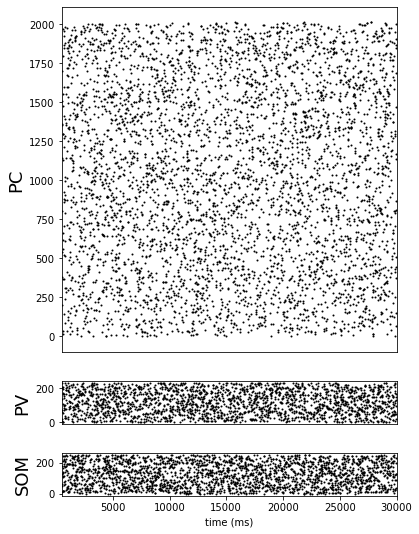

In [17]:
#networkModel_noSensoryInput(epsilon=0.02, sigmaC=0.1)
duration = 30 # s
pc, pv, som = networkModel_noSensoryInput(epsilon=0.02, sigmaC=0.1,duration=duration)
pcSpikes = np.zeros(np.amax(pc))
pvSpikes = np.zeros(np.amax(pv))
somSpikes= np.zeros(np.amax(som))
read_dur = duration - 0.5


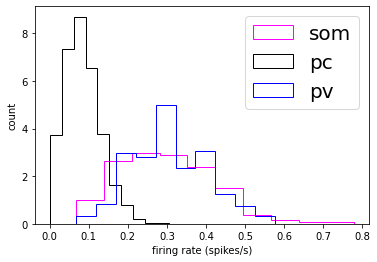

In [18]:
pcSpikes = np.zeros(np.amax(pc))
pvSpikes = np.zeros(np.amax(pv))
somSpikes= np.zeros(np.amax(som))
read_dur = duration - 0.5
for i in range(pc.max()):
    pcSpikes[i] = len(pc[pc==i])/read_dur
#print('pcSpikes = '+str(pcSpikes))
for i in range(pv.max()):
    pvSpikes[i] = len(pv[pv==i])/read_dur
#print('pvSpikes = '+str(pvSpikes))
for i in range(som.max()):
    somSpikes[i] = len(som[som==i])/read_dur
#print('somSpikes = '+str(somSpikes))
plt.hist(somSpikes,density=True,label='som',histtype='step',color='magenta')
#print(somhist)
plt.hist(pcSpikes,density=True,label='pc',histtype='step',color='black')
plt.hist(pvSpikes,density=True,label='pv',histtype='step',color='blue')
plt.xlabel('firing rate (spikes/s)')
plt.ylabel('count')
plt.legend(fontsize=20)
plt.savefig('2500nrns_hist.pdf',bbox_inches='tight')
plt.show()


# Test

In [66]:
epsilon = 0.02
sigmaC = 0.1

# shorthand
eps = epsilon
sig = sigmaC
# create the grid with neurons randomly placed
xVec, yVec, colors = make_grid(visualize=True)


number of PC neurons = 7900
number of PV neurons = 1020
number of SOM neurons= 1080
total number of neurons = 10000

proportion of PC neurons = 0.79
proportion of PV neurons = 0.102
proportion of SOM neurons= 0.108


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


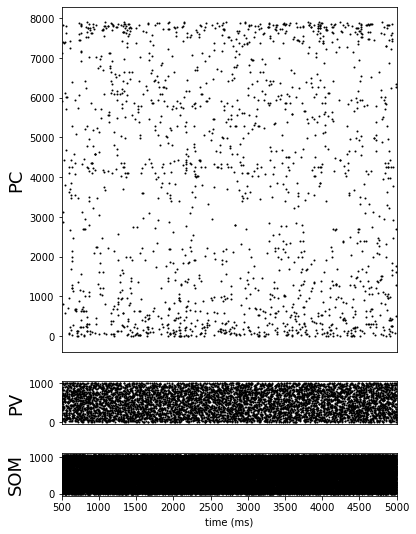

In [71]:
plotRaster=True
duration=5
# separate the positions by neuron class
xPC = xVec[colors=='r']
yPC = yVec[colors=='r']
rPC = np.array([xPC, yPC])
#print('type(rPC) = '+str(type(rPC)))
nPC = len(xPC)
xPV = xVec[colors=='b']
yPV = yVec[colors=='b']
rPV = np.array([xPV, yPV])
nPV = len(xPV)
xSOM= xVec[colors=='g']
ySOM= yVec[colors=='g']
rSOM = np.array([xSOM, ySOM])
nSOM = len(xSOM)
N = nPC + nPV + nSOM
#print('N = '+str(N))

xPCPVSOM = np.concatenate((xPC,xPV,xSOM),axis=0)
yPCPVSOM = np.concatenate((yPC,yPV,ySOM),axis=0)
rPCPVSOM = np.array([xPCPVSOM,yPCPVSOM])

nPCSOM = nPC + nSOM

xPVPC = np.concatenate((xPV,xPC),axis=0)
yPVPC = np.concatenate((yPV,yPC),axis=0)
rPVPC = np.array([xPVPC,yPVPC])
nPVPC = nPV + nPC

# create the distance-dependent connection matrices
C_PCPVSOMtoPC = makeC_dd(rPre=rPCPVSOM, rPost=rPC, epsilon=eps, sigmaC=sig, N=N)
C_PVPCtoPV = makeC_dd(rPre=rPVPC, rPost=rPV, epsilon=eps, sigmaC=sig, N=N)

# create the connection matrices that are not distance-dependent
C_PCSOMtoSOM = makeC(numPre=nPCSOM, numPost=nSOM, epsilon=eps, N=N)


# make the population pairwise matrices for BRIAN
C_PCtoPC = C_PCPVSOMtoPC[:nPC,]
C_PVtoPC = C_PCPVSOMtoPC[nPC:nPC+nPV,]
C_SOMtoPC = C_PCPVSOMtoPC[nPC+nPV:,]
C_PVtoPV = C_PVPCtoPV[:nPV,]
C_PCtoPV = C_PVPCtoPV[nPV:,]
C_PCtoSOM = C_PCSOMtoSOM[:nPC,]
C_SOMtoSOM= C_PCSOMtoSOM[nPC:,]

#### BEGIN BRIAN CODE ####

start_scope() # initialize BRIAN

## NUMERICAL INTEGRATION SETTINGS
defaultclock.dt = 0.1*ms # set time step
duration = duration*1000*ms # duration of trial

## PARAMETERS ##
# times
tau_m = 25*ms # time constant of voltage
tau_exc = 6*ms # time constant of excitatory synapses
tau_inh = 20*ms # time constant of inhibitory synapses
tau_ref = 5*ms # refractory period

# voltages
V_rest = -70*mV # resting voltage
V_reset= -65*mV # reset voltage
V_th = -40*mV # threshold voltage
E_exc = 0*mV # excitatory reversal potential
E_inh = -75*mV # inhibitory reversal potential

# conductances
w_exc = 1.5*nS # excitatory synaptic weight
w_inh = 30*nS # inhibitory synaptic weight
G_leak = 10*nS # leak conductance

# inputs
avgRate = 40*Hz # 40 spikes per second
wext_PC = 20*nS # external excitatory input (PC)
wext_PV = 15*nS # external inhibitory input to PV
wext_SOM= 2.5*nS # external inhibitory input to SOM
wadd_SOM= 1.5*nS # additional inhibitory input to SOM

##### MODEL EQUATIONS (see El-Boustani & Sur Nature Communications 2014) #####
eqs = '''
x : metre
y : metre
dV/dt  = ( (V_rest-V) + (gPV/G_leak)*(E_inh-V) + (gPC/G_leak)*(E_exc-V) + (gSOM/G_leak)*(E_inh-V) )/tau_m: volt (unless refractory)
dgPC/dt = -gPC/tau_exc : siemens
dgPV/dt = -gPV/tau_inh: siemens
dgSOM/dt = -gSOM/tau_inh: siemens
'''

# reset rules
reset = '''
V = V_reset
'''

##### NEURON GROUPs #####
PC = NeuronGroup(nPC, eqs, threshold='V>V_th', reset=reset, method='euler', refractory=tau_ref)
PV = NeuronGroup(nPV, eqs, threshold='V>V_th', reset=reset, method='euler', refractory=tau_ref)
SOM = NeuronGroup(nSOM, eqs, threshold='V>V_th', reset=reset, method='euler', refractory=tau_ref)

### INITIAL CONDITIONS ###
PC.V = 'rand()*(V_th-V_rest)+V_rest'
PC.gPC = 0*nS
PC.gPV = 0*nS
PC.gSOM = 0*nS

PV.V = 'rand()*(V_th-V_rest)+V_rest'
PV.gPC = 0*nS
PV.gPV = 0*nS
PV.gSOM = 0*nS

SOM.V = 'rand()*(V_th-V_rest)+V_rest'
SOM.gPC = 0*nS
SOM.gPV = 0*nS
SOM.gSOM = 0*nS

#print('PC.x = '+str(PC.x))

# ### POSITIONS ###
PC.x = np.array(xPC,dtype=float)*NRN_SPACING*metre/1000
PC.y = np.array(yPC,dtype=float)*NRN_SPACING*metre/1000
PV.x = np.array(xPV,dtype=float)*NRN_SPACING*metre/1000
PV.y = np.array(yPV,dtype=float)*NRN_SPACING*metre/1000
SOM.x = np.array(xSOM,dtype=float)*NRN_SPACING*metre/1000
SOM.y = np.array(ySOM,dtype=float)*NRN_SPACING*metre/1000

# external Poissonian PC input
extPCinputToPC = PoissonInput(
target=PC, target_var='gPC', N=1, rate=avgRate, weight=wext_PC
)
extPCinputToPV = PoissonInput(
target=PV, target_var='gPC', N=1, rate=avgRate, weight=wext_PC
)
extPCinputToSOM = PoissonInput(
target=SOM, target_var='gPC', N=1, rate=avgRate, weight=wext_PC
)

# external Poissonian PV input
extPVinputToPC = PoissonInput(
target=PC, target_var='gPV', N=1, rate=avgRate, weight=wext_PV
)
extPVinputToPV = PoissonInput(
target=PV, target_var='gPV', N=1, rate=avgRate, weight=wext_PV
)
# extPVinputToSOM = PoissonInput(
# target=SOM, target_var='gPV', N=nSOM, rate=avgRate, weight=wext_PV
# )

# external Poissonian SOM input
extSOMinputToPC = PoissonInput(
target=PC, target_var='gSOM', N=1, rate=avgRate, weight=wext_SOM
)
# extSOMinputToPV = PoissonInput(
# target=PV, target_var='gSOM', N=nPV, rate=avgRate, weight=wext_SOM
# )
extSOMinputToSOM = PoissonInput(
target=SOM, target_var='gSOM', N=1, rate=avgRate, weight=wext_SOM
)

# additional Poissonian SOM input
addSOMinputToSOM = PoissonInput(
target=SOM, target_var='gSOM', N=1, rate=avgRate, weight=wadd_SOM
)


##### SYNAPSES #####
## incoming connections to PV
# PV inhibits PV
PVtoPVpre, PVtoPVpost = C_PVtoPV.nonzero()
PVtoPV = Synapses(PV, PV,
                  on_pre='''
                  gPV_post += w_inh
                  ''')
PVtoPV.connect(i=PVtoPVpre, j=PVtoPVpost)
PVtoPV.delay = '10*ms*( (x_pre-x_post)**2 + (y_pre-y_post)**2 )**(1/2)/mmetre'

# PC excites PV
PCtoPVpre, PCtoPVpost = C_PCtoPV.nonzero()
PCtoPV = Synapses(PC, PV,
                  on_pre='''
                  gPC_post += w_exc
                  ''')
PCtoPV.connect(i=PCtoPVpre, j=PCtoPVpost)
PCtoPV.delay = '10*ms*( (x_pre-x_post)**2 + (y_pre-y_post)**2 )**(1/2)/mmetre'

#SOM inhibits PV
# SOMtoPVpre, SOMtoPVpost = C_


## incoming connections to PC
# PC excites PC
PCtoPCpre, PCtoPCpost = C_PCtoPC.nonzero()
PCtoPC = Synapses(PC, PC,
                  on_pre='''
                  gPC_post += w_exc
                  ''')
PCtoPC.connect(i=PCtoPCpre, j=PCtoPCpost)
PCtoPC.delay = '10*ms*( (x_pre-x_post)**2 + (y_pre-y_post)**2 )**(1/2)/mmetre'
#print(C_PVtoPC.nonzero())
# PV inhibits PC
PVtoPCpre, PVtoPCpost = C_PVtoPC.nonzero()
PVtoPC = Synapses(PV, PC,
                  on_pre='''
                  gPV_post += w_inh
                  ''')
PVtoPC.connect(i=PVtoPCpre, j=PVtoPCpost)
PVtoPC.delay = '10*ms*( (x_pre-x_post)**2 + (y_pre-y_post)**2 )**(1/2)/mmetre'
# SOM inhibits PC
SOMtoPCpre, SOMtoPCpost = C_SOMtoPC.nonzero()
SOMtoPC = Synapses(SOM, PC,
                  on_pre='''
                  gSOM_post += w_inh
                  ''')
SOMtoPC.connect(i=SOMtoPCpre, j=SOMtoPCpost)
SOMtoPC.delay = '10*ms*( (x_pre-x_post)**2 + (y_pre-y_post)**2 )**(1/2)/mmetre'
## incoming connections to SOM
# SOM inhibits SOM
#     SOMtoSOMpre, SOMtoSOMpost = C_SOMtoSOM.nonzero()
#     SOMtoSOM = Synapses(SOM, SOM,
#                       on_pre='''
#                       gSOM_post += w_inh
#                       ''')
#     SOMtoSOM.connect(i=SOMtoSOMpre, j=SOMtoSOMpost)
#     SOMtoSOM.delay = '10*ms*( (x_pre-x_post)**2 + (y_pre-y_post)**2 )**(1/2)/mmetre'
# PC excites SOM
PCtoSOMpre, PCtoSOMpost = C_PCtoSOM.nonzero()
PCtoSOM = Synapses(PC, SOM,
                  on_pre='''
                  gPC_post += w_exc
                  ''')
PCtoSOM.connect(i=PCtoSOMpre, j=PCtoSOMpost)
PCtoSOM.delay = '10*ms*( (x_pre-x_post)**2 + (y_pre-y_post)**2 )**(1/2)/mmetre'    

#### MONITORS 
spikeMonPC = SpikeMonitor(PC, 'V')
spikeMonPV = SpikeMonitor(PV, 'V')
spikeMonSOM = SpikeMonitor(SOM, 'V')

# run the simulation for a duration 'duration'
run(duration)

if plotRaster:
    fig, axes = plt.subplots(3,1,figsize = (6,9),gridspec_kw = {'height_ratios':[8,1,1]})

    ax0 = axes[0]
    ax0.plot(spikeMonPC.t[spikeMonPC.t/ms > 500]/ms, spikeMonPC.i[spikeMonPC.t/ms > 500], '.k', markersize=2)
    ax0.set_xticks([])
    ax0.set_xlim([500,duration/ms])
    ax0.set_ylabel('PC',fontsize=18)
    ax0.tick_params(
        axis='y',          # changes apply to the x-axis
        labelsize=10) # labels along the bottom edge are off

    ax1 = axes[1]
    ax1.plot(spikeMonPV.t[spikeMonPV.t/ms > 500]/ms, spikeMonPV.i[spikeMonPV.t/ms > 500], '.k', markersize=2)
    ax1.set_xticks([])
    ax1.set_xlim([500,duration/ms])
    ax1.set_ylabel('PV',fontsize=18)
    ax1.tick_params(
        axis='y',          # changes apply to the x-axis
        labelsize=10) # labels along the bottom edge are off

    ax2 = axes[2]
    ax2.plot(spikeMonSOM.t[spikeMonSOM.t/ms > 500]/ms, spikeMonSOM.i[spikeMonSOM.t/ms > 500], '.k', markersize=2)
    #ax2.set_xticks([])
    ax2.set_xlim([500,duration/ms])
    ax2.set_xlabel('time (ms)')
    ax2.set_ylabel('SOM', fontsize=18)
    ax2.tick_params(
        axis='y',          # changes apply to the x-axis
        labelsize=10) # labels along the bottom edge are off

    plt.savefig('2500nrns_raster.pdf',bbox_inches='tight')
    plt.show()
    plt.close()
# return [spikeMonPC.i[spikeMonPC.t/ms > 500], spikeMonPV.i[spikeMonPV.t/ms > 500], spikeMonSOM.i[spikeMonSOM.t/ms > 500]]


WARNING    /usr/local/pace-apps/manual/packages/anaconda-individual/2021.05/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
 [py.warnings]


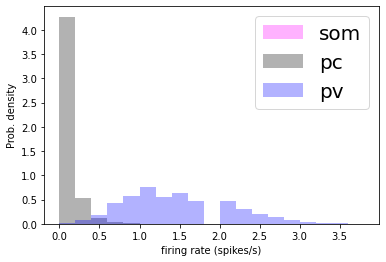

In [72]:
pc, pv, som = spikeMonPC.i[spikeMonPC.t/ms > 500], spikeMonPV.i[spikeMonPV.t/ms > 500], spikeMonSOM.i[spikeMonSOM.t/ms > 500]
duration = 5
pcSpikes = np.zeros(np.amax(pc))
pvSpikes = np.zeros(np.amax(pv))
somSpikes= np.zeros(np.amax(som))
read_dur = duration - 0.5
for i in range(pc.max()):
    pcSpikes[i] = len(pc[pc==i])/read_dur
#print('pcSpikes = '+str(pcSpikes))
for i in range(pv.max()):
    pvSpikes[i] = len(pv[pv==i])/read_dur
#print('pvSpikes = '+str(pvSpikes))
for i in range(som.max()):
    somSpikes[i] = len(som[som==i])/read_dur
#print('somSpikes = '+str(somSpikes))
bins = [0.2*iii for iii in range(20)]
plt.hist(somSpikes,density=True,label='som',bins=bins,color='magenta', facecolor='magenta',alpha=0.3)
#print(somhist)
plt.hist(pcSpikes,density=True,label='pc',bins=bins,color='black',facecolor='black',alpha=0.3)
plt.hist(pvSpikes,density=True,label='pv',bins=bins,color='blue',facecolor='blue',alpha=0.3)
plt.xlabel('firing rate (spikes/s)')
plt.ylabel('Prob. density')
plt.legend(fontsize=20)
plt.savefig('10000nrns_hist.png',bbox_inches='tight')
plt.show()


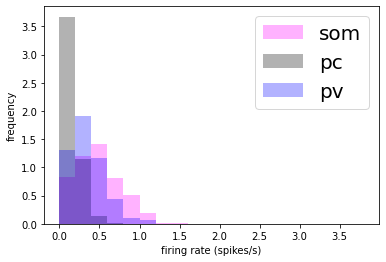

In [64]:
pc, pv, som = spikeMonPC.i[spikeMonPC.t/ms > 500], spikeMonPV.i[spikeMonPV.t/ms > 500], spikeMonSOM.i[spikeMonSOM.t/ms > 500]
duration = 5
pcSpikes = np.zeros(np.amax(pc))
pvSpikes = np.zeros(np.amax(pv))
somSpikes= np.zeros(np.amax(som))
read_dur = duration - 0.5
for i in range(pc.max()):
    pcSpikes[i] = len(pc[pc==i])/read_dur
#print('pcSpikes = '+str(pcSpikes))
for i in range(pv.max()):
    pvSpikes[i] = len(pv[pv==i])/read_dur
#print('pvSpikes = '+str(pvSpikes))
for i in range(som.max()):
    somSpikes[i] = len(som[som==i])/read_dur
#print('somSpikes = '+str(somSpikes))
bins = [0.2*iii for iii in range(20)]
plt.hist(somSpikes,density=True,label='som',bins=bins,color='magenta', facecolor='magenta',alpha=0.3)
#print(somhist)
plt.hist(pcSpikes,density=True,label='pc',bins=bins,color='black',facecolor='black',alpha=0.3)
plt.hist(pvSpikes,density=True,label='pv',bins=bins,color='blue',facecolor='blue',alpha=0.3)
plt.xlabel('firing rate (spikes/s)')
plt.ylabel('Prob. density')
plt.legend(fontsize=20)
plt.savefig('2500nrns_hist.pdf',bbox_inches='tight')
plt.show()
